In [2]:
import pandas as pd
import os
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

payload_size_dict = {'U': [1048,1056,1090], 'T': [1066]}
CC_DICT = {
    # "dctcp": 8,
    # "dcqcn_paper_vwin": 1,
    "hp": 3,
    "timely_vwin": 7,
    "powertcp": 9,
    "thetapowertcp": 10,
    "bbr": 15,
    "bic": 16,
    "cubic": 17,
    "dctcp": 18,
    "high_speed": 19,
    "htcp": 20,
    "hybla": 21,
    "illinois": 22,
    "led_bat": 23,
    "lp": 24,
    "scalable": 25,
    "vegas": 26,
    "veno": 27,
    "westwood": 28,
    "yeah": 29,
    "linux_reno": 30
}
seed_to_cc=list(CC_DICT.keys())

def parse_log_entry(line):
    parts = line.split()
    
    node = int(parts[1].split(':')[1])
    
    pkt_type = parts[10]
    data_pkt = pkt_type=='U' or pkt_type=='T'
    payload_size = int(parts[-1].split('(')[0]) 
    event_type = parts[4]
    
    if not data_pkt or node != 3 or event_type not in ['Enqu', 'Dequ'] or payload_size not in payload_size_dict[pkt_type]:
        return None
    else:
        timestamp = int(parts[0])
        
        queue_info = parts[2].split(':')
        port = int(queue_info[0])
        queue = int(queue_info[1])
        # payload_size = int(parts[-1].split('(')[1].split(')')[0])
        queue_len= int(parts[3])
        return {
            'timestamp': timestamp,
            'node': node,
            'port': port,
            'queue': queue,
            'payload_size': payload_size,
            'event_type': event_type,
            'data_pkt': data_pkt,
            'queue_len': queue_len
        }

def calculate_throughput_and_delay(log_file):
    start_time=None
    end_time=None
    enqu_timestamps = deque()
    total_payload = 0
    queuing_delay_list = []
    with open(log_file, 'r') as file:
        for line in file:
            entry = parse_log_entry(line)
            if entry:
                assert entry['node'] == 3 and entry['port'] == 3 and entry['queue'] in [1,3]
                if start_time is None:
                    start_time = entry['timestamp']
                end_time = entry['timestamp']
                if entry['event_type'] == 'Enqu':
                    enqu_timestamps.append(entry['timestamp'])
                elif entry['event_type'] == 'Dequ':
                    total_payload += entry['payload_size']
                    if enqu_timestamps:
                        queuing_delay_list.append(entry['timestamp'] - enqu_timestamps.popleft())

    total_time = end_time - start_time
    throughput = total_payload * 8 / total_time
    average_queuing_delay = np.mean(queuing_delay_list)  if len(queuing_delay_list) > 0 else 0
    return throughput, average_queuing_delay,queuing_delay_list

shard=0
nhosts=3

# shard_seed_list=[6,7,19]
shard_seed_list=[6,7,19]
# nflows_list=[1,50]
# bw_list=[1,5,9]
# pd_list=[1000,5000,9000]
nflows_list=np.array([1,5,9])
bw_list=np.array([10, 14, 18])
pd_list=np.array([10000, 14000, 18000])

plot_list=np.zeros((len(shard_seed_list),len(nflows_list),len(bw_list),len(pd_list),2))
for nflows_idx,nflows in enumerate(nflows_list):
    data_dir=f"/data2/lichenni/path_cc20/shard{shard}_nflows{nflows}_nhosts{nhosts}"
    for shard_seed_idx,shard_seed in enumerate(shard_seed_list):
        for bw_idx,bw in enumerate(bw_list):
            for pd_idx,pd in enumerate(pd_list):
                tr_path=f"{data_dir}/mix_topo-pl-{nhosts}-{bw}-{pd}_s{shard_seed}.tr"
                print(tr_path)
                
                # Read and parse the log file
                log_path = tr_path.replace('.tr', '.log')

                if not os.path.exists(log_path):
                    os.system(f"./trace_reader {tr_path} > {log_path}")
                    
                throughput, queuing_delay,queuing_delay_list = calculate_throughput_and_delay(log_path)
                # print(f"{log_path}. Throughput: {throughput}Gbps, Queuing Delay: {queuing_delay}ns")

                plot_list[shard_seed_idx,nflows_idx,bw_idx,pd_idx,0]=throughput
                plot_list[shard_seed_idx,nflows_idx,bw_idx,pd_idx,1]=queuing_delay
                # plt.figure(figsize=(4, 3))
                # plt.plot(np.array(queuing_delay_list), '-o')
                # plt.xlabel('Per packet')
                # plt.ylabel('Per-pkt Queuing Delay (ns)')
                # # plt.ylim(top=queue_size_top,bottom=queue_size_bottom)
                # plt.title(f'{log_path.split("/")[-1]}')
                # plt.legend()
                # plt.tight_layout()
                # plt.show()
                

/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-10000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-14000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-18000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-14-10000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-14-14000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-14-18000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-18-10000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-18-14000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-18-18000_s6.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-10000_s7.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-14000_s7.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-10-18000_s7.tr
/data2/lichenni/path_cc20/shard0_nflows1_nhosts3/mix_topo-pl-3-1

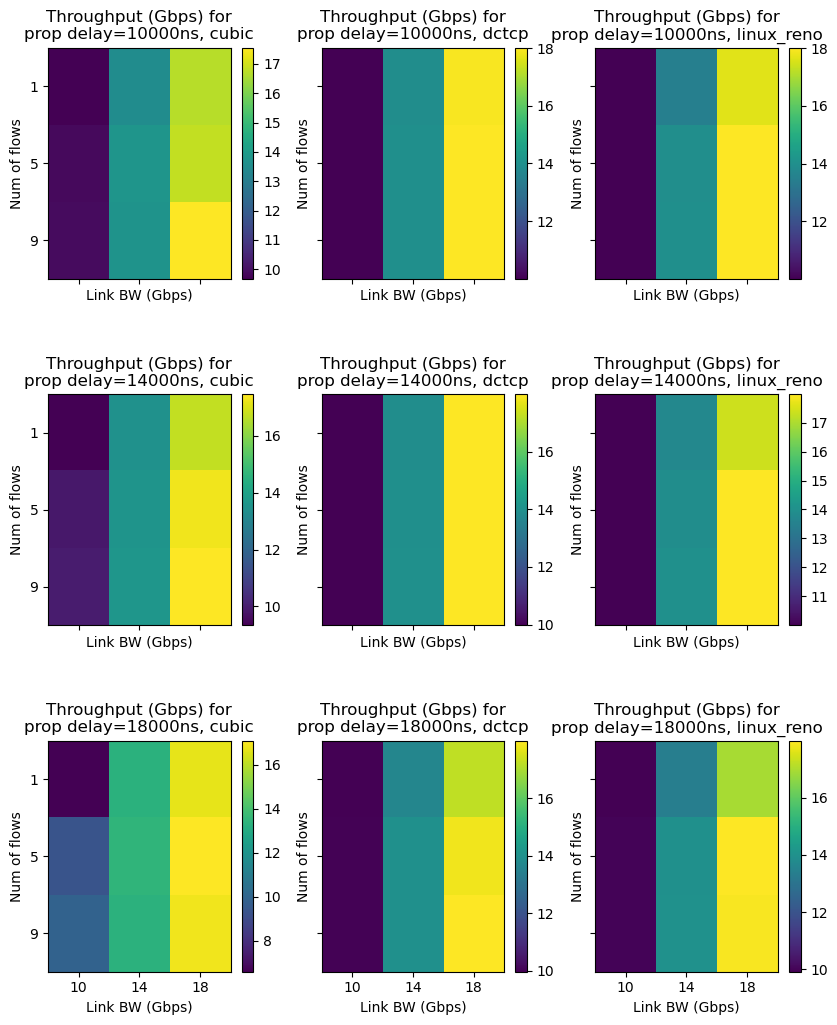

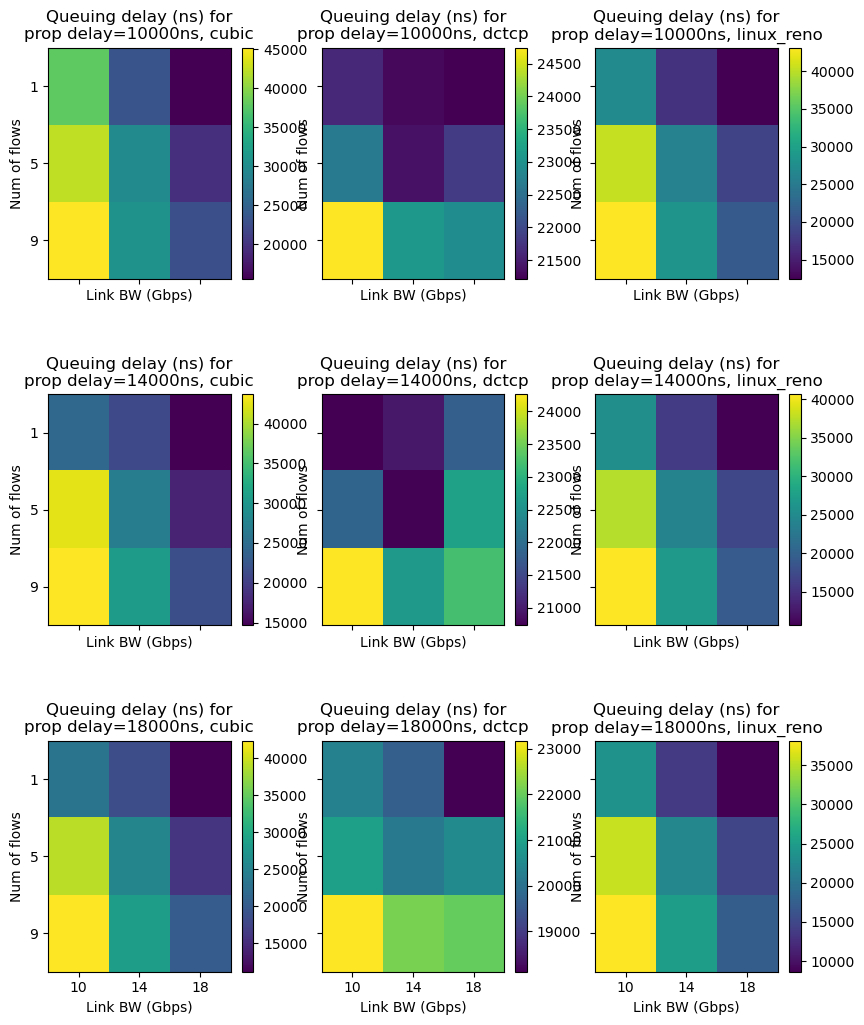

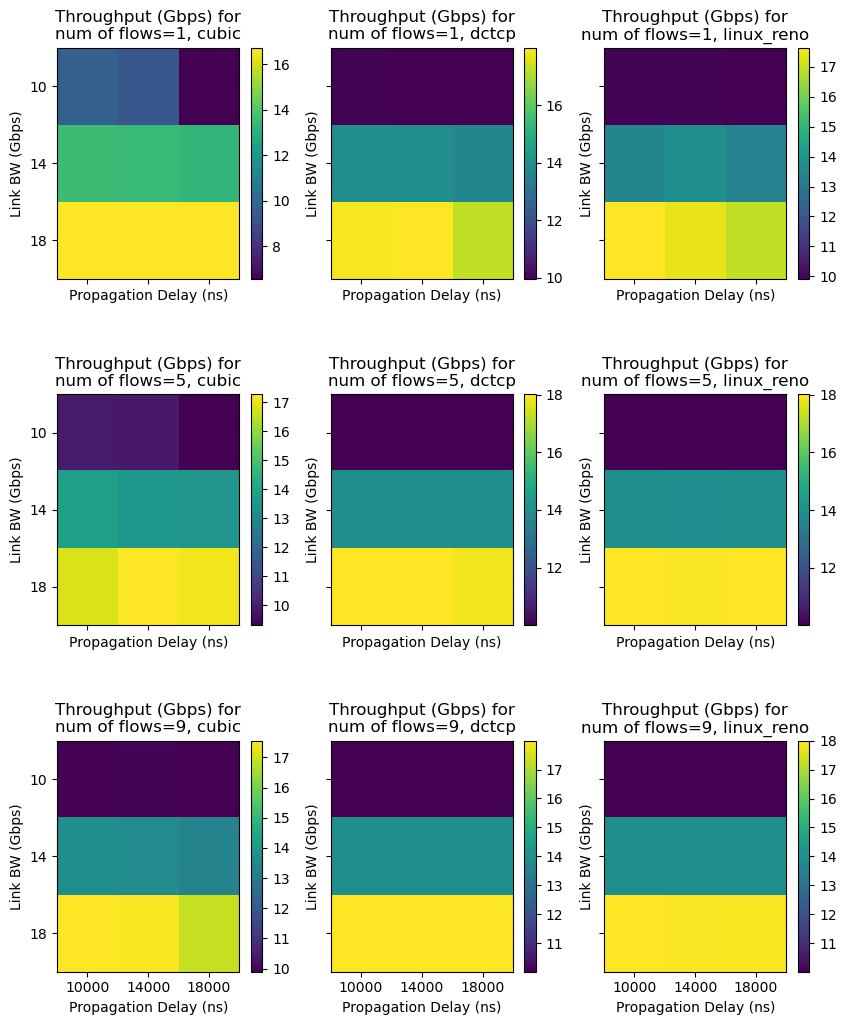

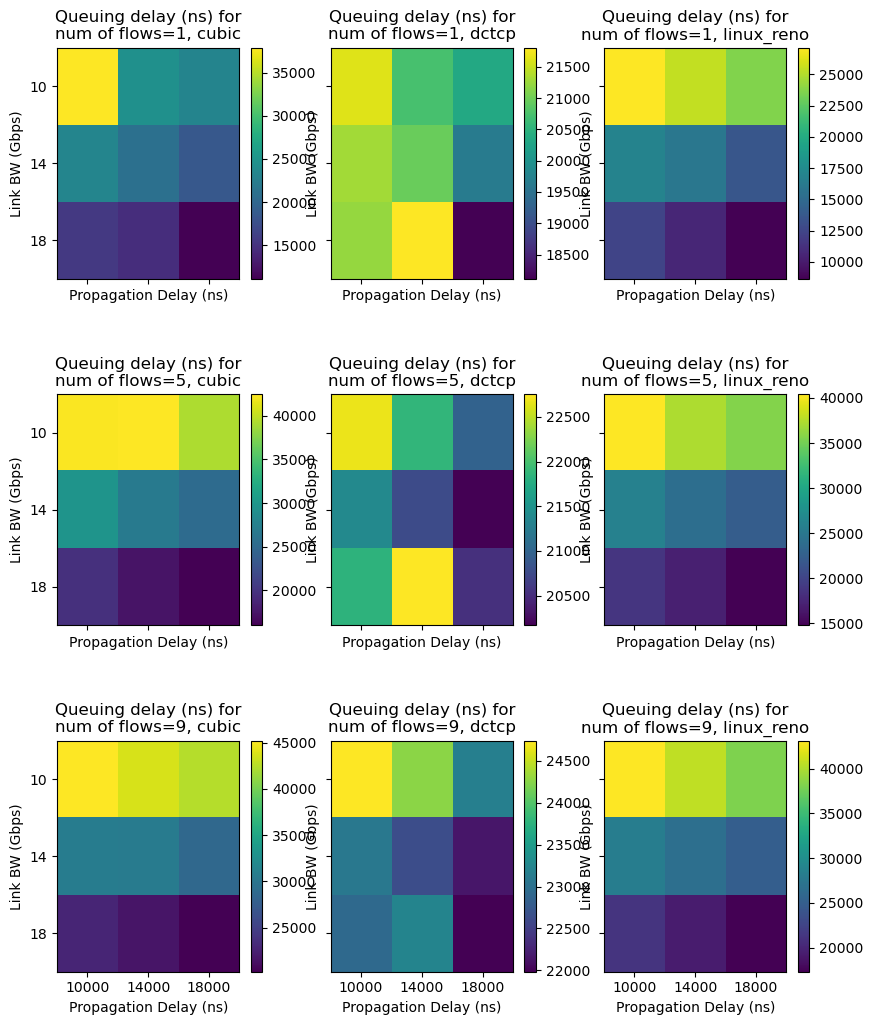

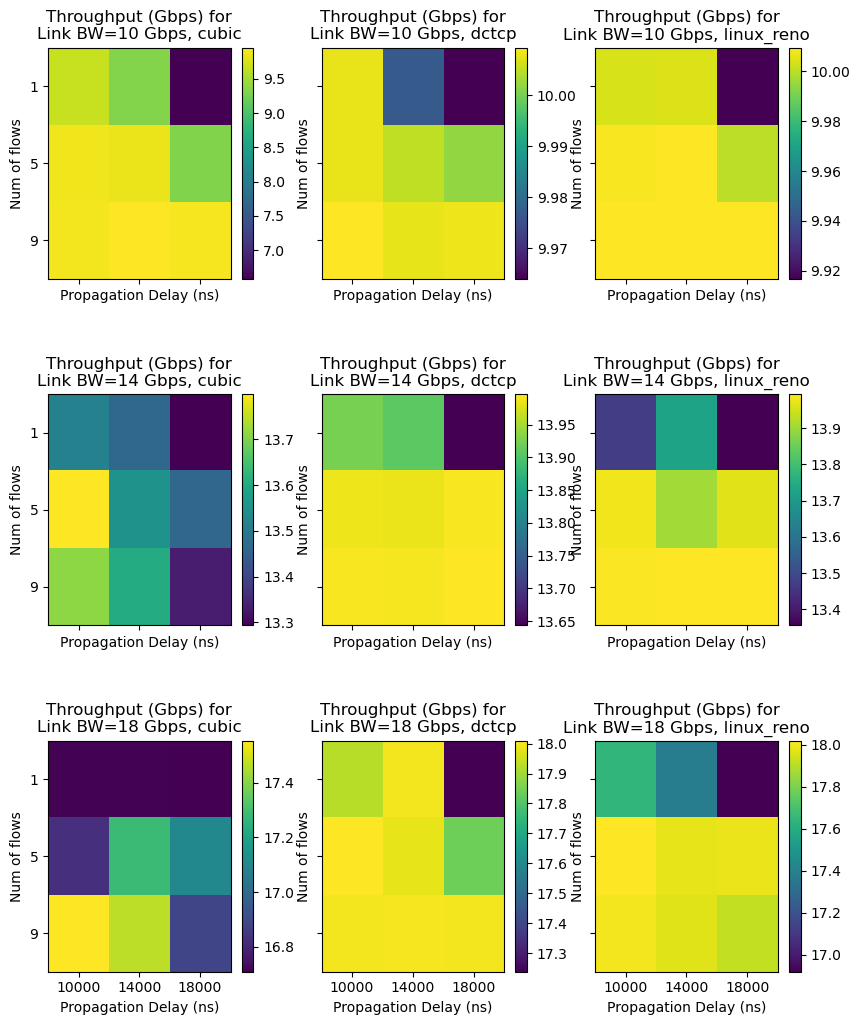

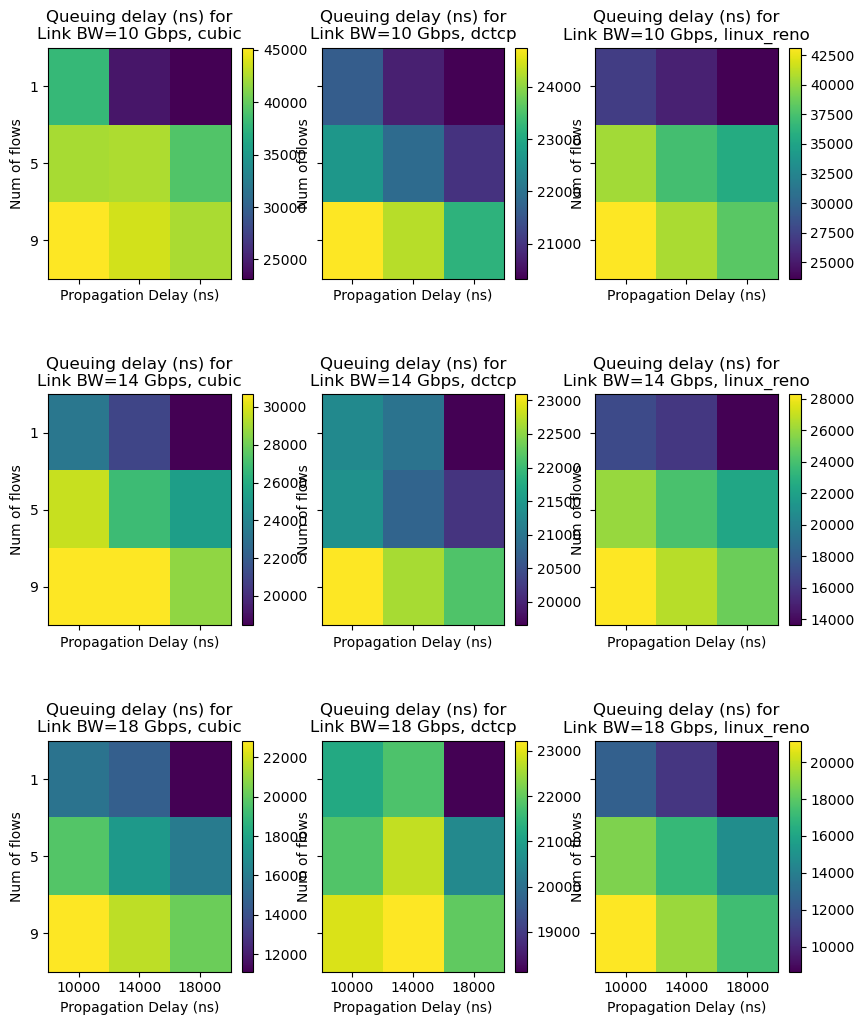

In [3]:
# Create subplots grid for throughput
fig, axs = plt.subplots(len(pd_list), len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for pd_idx, pd in enumerate(pd_list):
        im = axs[pd_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,:, :, pd_idx, 0], cmap='viridis', aspect='auto')
        axs[pd_idx,shard_seed_idx].set_ylabel('Num of flows')
        axs[pd_idx,shard_seed_idx].set_xlabel('Link BW (Gbps)')
        axs[pd_idx,shard_seed_idx].set_title(f'Throughput (Gbps) for\nprop delay={pd}ns, {seed_to_cc[shard_seed]}')
        axs[pd_idx,shard_seed_idx].set_xticks(np.arange(len(bw_list)))
        axs[pd_idx,shard_seed_idx].set_xticklabels(bw_list)
        axs[pd_idx,shard_seed_idx].set_yticks(np.arange(len(nflows_list)))
        axs[pd_idx,shard_seed_idx].set_yticklabels(nflows_list)
        fig.colorbar(im, ax=axs[pd_idx,shard_seed_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(pd_list), len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for pd_idx, pd in enumerate(pd_list):
        im = axs2[pd_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,:, :, pd_idx, 1], cmap='viridis', aspect='auto')
        axs2[pd_idx,shard_seed_idx].set_ylabel('Num of flows')
        axs2[pd_idx,shard_seed_idx].set_xlabel('Link BW (Gbps)')
        axs2[pd_idx,shard_seed_idx].set_title(f'Queuing delay (ns) for\nprop delay={pd}ns, {seed_to_cc[shard_seed]}')
        axs2[pd_idx,shard_seed_idx].set_xticks(np.arange(len(bw_list)))
        axs2[pd_idx,shard_seed_idx].set_xticklabels(bw_list)
        axs2[pd_idx,shard_seed_idx].set_yticks(np.arange(len(nflows_list)))
        axs2[pd_idx,shard_seed_idx].set_yticklabels(nflows_list)
        fig.colorbar(im, ax=axs2[pd_idx,shard_seed_idx])

# Create subplots grid for throughput
fig, axs = plt.subplots(len(nflows_list), len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for nflows_idx, nflows in enumerate(nflows_list):
        im = axs[nflows_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,nflows_idx, :, :, 0], cmap='viridis', aspect='auto')
        axs[nflows_idx,shard_seed_idx].set_ylabel('Link BW (Gbps)')
        axs[nflows_idx,shard_seed_idx].set_xlabel('Propagation Delay (ns)')
        axs[nflows_idx,shard_seed_idx].set_title(f'Throughput (Gbps) for\nnum of flows={nflows}, {seed_to_cc[shard_seed]}')
        axs[nflows_idx,shard_seed_idx].set_xticks(np.arange(len(pd_list)))
        axs[nflows_idx,shard_seed_idx].set_xticklabels(pd_list)
        axs[nflows_idx,shard_seed_idx].set_yticks(np.arange(len(bw_list)))
        axs[nflows_idx,shard_seed_idx].set_yticklabels(bw_list)
        fig.colorbar(im, ax=axs[nflows_idx,shard_seed_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(nflows_list),  len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for nflows_idx, nflows in enumerate(nflows_list):
        im = axs2[nflows_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,nflows_idx, :, :, 1], cmap='viridis', aspect='auto')
        axs2[nflows_idx,shard_seed_idx].set_ylabel('Link BW (Gbps)')
        axs2[nflows_idx,shard_seed_idx].set_xlabel('Propagation Delay (ns)')
        axs2[nflows_idx,shard_seed_idx].set_title(f'Queuing delay (ns) for\nnum of flows={nflows}, {seed_to_cc[shard_seed]}')
        axs2[nflows_idx,shard_seed_idx].set_xticks(np.arange(len(pd_list)))
        axs2[nflows_idx,shard_seed_idx].set_xticklabels(pd_list)
        axs2[nflows_idx,shard_seed_idx].set_yticks(np.arange(len(bw_list)))
        axs2[nflows_idx,shard_seed_idx].set_yticklabels(bw_list)
        fig.colorbar(im, ax=axs2[nflows_idx,shard_seed_idx])

# Create subplots grid for throughput
fig, axs = plt.subplots(len(bw_list),  len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for bw_idx, bw in enumerate(bw_list):
        im = axs[bw_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,:, bw_idx, :, 0], cmap='viridis', aspect='auto')
        axs[bw_idx,shard_seed_idx].set_ylabel('Num of flows')
        axs[bw_idx,shard_seed_idx].set_xlabel('Propagation Delay (ns)')
        axs[bw_idx,shard_seed_idx].set_title(f'Throughput (Gbps) for\nLink BW={bw} Gbps, {seed_to_cc[shard_seed]}')
        axs[bw_idx,shard_seed_idx].set_xticks(np.arange(len(pd_list)))
        axs[bw_idx,shard_seed_idx].set_xticklabels(pd_list)
        axs[bw_idx,shard_seed_idx].set_yticks(np.arange(len(nflows_list)))
        axs[bw_idx,shard_seed_idx].set_yticklabels(nflows_list)
        fig.colorbar(im, ax=axs[bw_idx,shard_seed_idx])

# Create subplots grid for queuing delay
fig, axs2 = plt.subplots(len(bw_list),  len(shard_seed_list), figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots
for shard_seed_idx, shard_seed in enumerate(shard_seed_list):
    for bw_idx, bw in enumerate(bw_list):
        im = axs2[bw_idx,shard_seed_idx].imshow(plot_list[shard_seed_idx,:, bw_idx, :, 1], cmap='viridis', aspect='auto')
        axs2[bw_idx,shard_seed_idx].set_ylabel('Num of flows')
        axs2[bw_idx,shard_seed_idx].set_xlabel('Propagation Delay (ns)')
        axs2[bw_idx,shard_seed_idx].set_title(f'Queuing delay (ns) for\nLink BW={bw} Gbps, {seed_to_cc[shard_seed]}')
        axs2[bw_idx,shard_seed_idx].set_xticks(np.arange(len(pd_list)))
        axs2[bw_idx,shard_seed_idx].set_xticklabels(pd_list)
        axs2[bw_idx,shard_seed_idx].set_yticks(np.arange(len(nflows_list)))
        axs2[bw_idx,shard_seed_idx].set_yticklabels(nflows_list)
        fig.colorbar(im, ax=axs2[bw_idx,shard_seed_idx])